In [120]:
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
import numpy as np
path_to_trackml = os.path.expanduser("~/trackml")
sys.path.append(os.path.join(path_to_trackml, "trackml-library"))
from trackml.dataset import load_dataset
from trackml.score import score_event

In [151]:
hits_list = []
particles_list = []
truth_list = []
for event_id, h, p, t in load_dataset(os.path.join(path_to_trackml, "train_1"),
                                      parts=["hits", "particles", "truth"],
                                      nevents=10):
    h["event_id"] = np.ones(len(h), dtype=int) * event_id
    p["event_id"] = np.ones(len(p), dtype=int) * event_id
    t["event_id"] = np.ones(len(t), dtype=int) * event_id
    hits_list.append(h)
    particles_list.append(p)
    truth_list.append(t)
hits = pd.concat(hits_list)
particles = pd.concat(particles_list)
truth = pd.concat(truth_list)    

# Looking volume id etc

In [24]:
for lbl in ["volume_id", "layer_id", "module_id"]:
    display(np.unique(hits[lbl]))

array([ 7,  8,  9, 12, 13, 14, 16, 17, 18], dtype=int32)

array([ 2,  4,  6,  8, 10, 12, 14], dtype=int32)

array([   1,    2,    3, ..., 3189, 3191, 3192], dtype=int32)

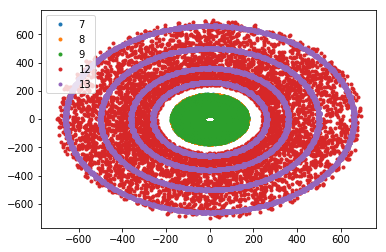

In [29]:
for vid in [7, 8, 9, 12, 13]:
    df = hits[hits.volume_id==vid]
    x = df["x"]
    y = df["y"]
    plt.plot(x, y, ".", label=str(vid))
plt.legend()    

# volume id and layer id

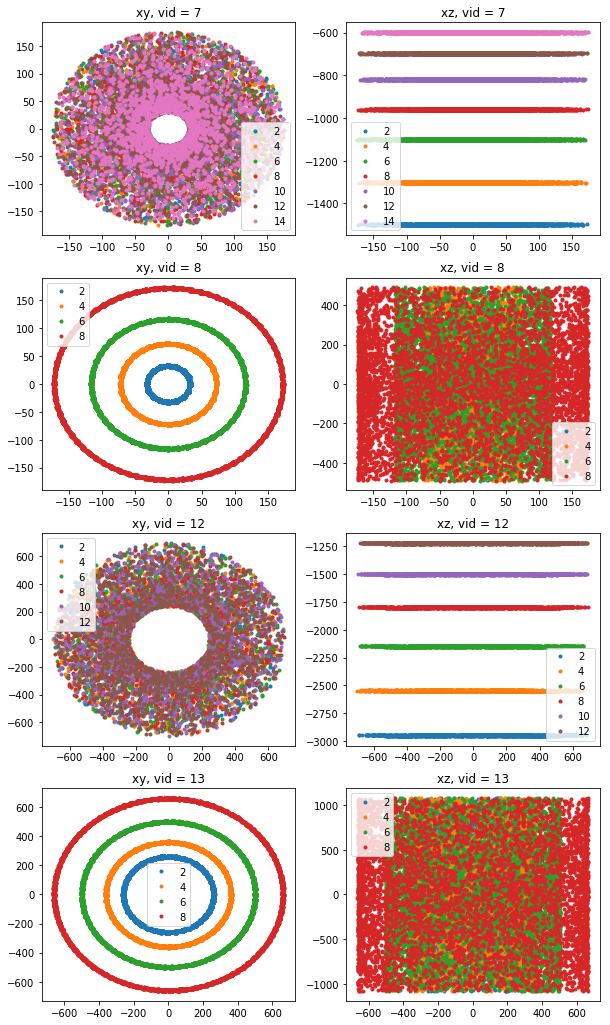

In [66]:
plt.figure(figsize=(10, 18))
vids = [7, 8, 12, 13]
numv = len(vids)
for i, vid in enumerate([7, 8, 12, 13]):
    df = hits[hits.volume_id==vid]
    lids = np.unique(df["layer_id"])
    
    plt.subplot(numv,2,2*i+1)
    for lid in lids:
        dff = df[df.layer_id==lid]
        plt.plot(dff["x"], dff["y"], ".", label=str(lid))
    plt.legend()
    plt.title("xy, vid = {0}".format(vid))
    
    plt.subplot(numv,2,2*i+2)
    for lid in lids:
        dff = df[df.layer_id==lid]
        plt.plot(dff["x"], dff["z"], ".", label=str(lid))
    plt.legend()
    plt.title("xz, vid = {0}".format(vid))

# module id

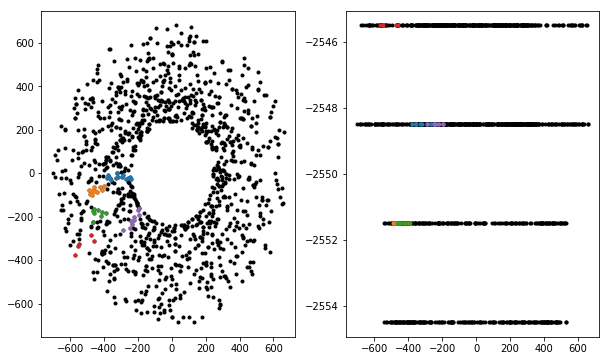

In [62]:
vid = 12
lid = 4
df = hits[(hits.volume_id==vid) & (hits.layer_id==lid)]
mids = df["module_id"].unique()
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.plot(df["x"], df["y"], "k.")
for mid in mids[:25:5]:
    dff = df[df.module_id==mid]
    plt.plot(dff["x"], dff["y"], ".")
    
plt.subplot(122)
plt.plot(df["x"], df["z"], "k.")
for mid in mids[:25:5]:
    dff = df[df.module_id==mid]
    plt.plot(dff["x"], dff["z"], ".")

# 3D plot

Text(0.5,0,'z')

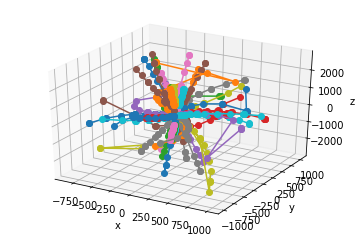

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for pid in pids:
    df = truth[truth.particle_id==pid]
    df.sort_values(by="tz")
    x, y, z = [df[lbl].values for lbl in ["tx", "ty", "tz"]]
    ax.plot(x, y, z, marker='o')    
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

# estimate (w,vz,rc,tc)

In [176]:
max_nhit = particles["nhits"].max()
epids = particles[particles.nhits>2][["event_id", "particle_id"]].values
print(len(epids))

89082


In [6]:
def adjust_theta(thetas):
    """
    transform angles to smoothly connect ones
    """
    new_theta = np.zeros(len(theta))
    new_theta[0] = theta[0]
    for i in range(len(theta)):
        if(i==0):
            continue
        t0 = new_theta[i-1]
        t1 = theta[i]
        n = round((t1-t0)/(2*np.pi))
        new_theta[i] = theta[i]-2*n*np.pi
    return new_theta

In [232]:
# if particle are moved precisely in helix (x,y) plane angle theta and z satisfy following linear equation
#        theta = w/v z + theta0.
# Seeing following plot, this equation is valid.

from sklearn.linear_model import LinearRegression
from tqdm import tqdm
wvs = []
theta0s = []
scores = []
model = LinearRegression()
for [eid, pid] in tqdm(epids, total=len(epids)):
    df = truth[(truth.particle_id==pid) & (truth.event_id==eid)].sort_values(by="tz")
    z = df["tz"]
    theta = np.arctan2(df["ty"].values, df["tx"].values)
    theta = adjust_theta(theta)
    x, y = [np.transpose(np.array([v])) for v in [z, theta]]
    model.fit(x, y)
    wvs.append(model.coef_[0,0])
    theta0s.append(model.intercept_[0])
    scores.append(model.score(x, y))

100%|██████████| 89082/89082 [15:35<00:00, 95.23it/s]


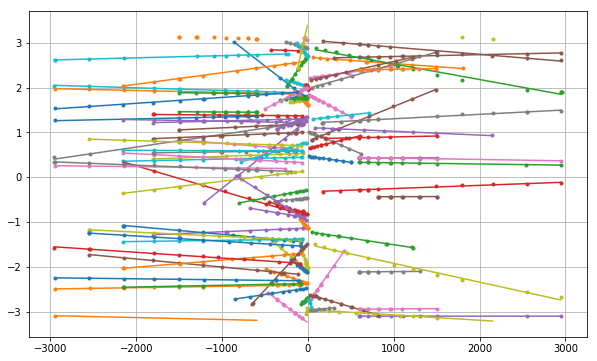

In [185]:
plt.figure(figsize=(10,6))
for (i,[eid, pid]) in enumerate(epids[:100]): 
    df = truth[(truth.particle_id==pid) & (truth.event_id==eid)].sort_values(by="tz")
    z = df["tz"]
    theta = np.arctan2(df["ty"].values, df["tx"].values)
    gla, = plt.plot(z, theta, ".")
    plt.plot(z, wvs[i]*z+theta0s[i], "-", color=gla.get_color())
plt.grid()    

In precise helix motion, z momentum must be constant. So, w can be extracted.
>    w = (w/v) * v = (w/v) * pz/m


In [237]:
particles2 = pd.DataFrame({"particle_id": epids[:,1], 
                           "event_id": epids[:,0],
                           "theta0": theta0s, 
                           "wv":wvs, 
                           "wm": wvs,
                           "score": scores})
particles2 = pd.merge(particles2, particles, on=["event_id", "particle_id"])
particles2["wm"] = particles2["wv"]*particles2["pz"]

In [260]:
scores = np.array(scores)
len(scores[np.where(scores>0.99)]), len(scores)

(67267, 89082)

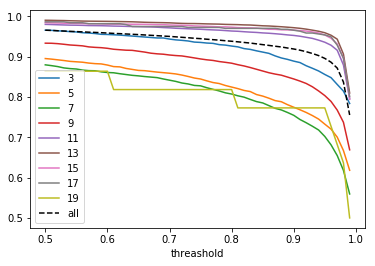

In [277]:
max_nhits = particles2["nhits"].max()
ths = np.linspace(0.5, 0.99, 50)
for nhits in range(3, max_nhits, 2):
    df = particles2[particles2.nhits==nhits]
    percentages = [len(df[df.score>threashold])/len(df) for threashold in ths]
    plt.plot(ths, percentages, label=str(nhits))
df = particles2
percentages = [len(df[df.score>threashold])/len(df) for threashold in ths]
plt.plot(ths, percentages, "k--", label="all")
plt.xlabel("threashold")
plt.legend()    

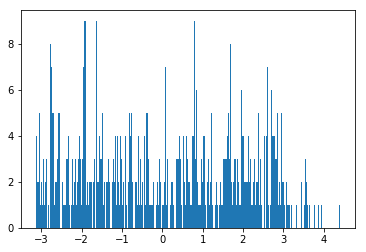

In [192]:
theta0 = particle2["theta0"].values
theta0 = np.where(abs(theta0)>np.pi, np.mod(theta0, 2*np.pi), theta0)
tmp = plt.hist(theta0, bins=300)              

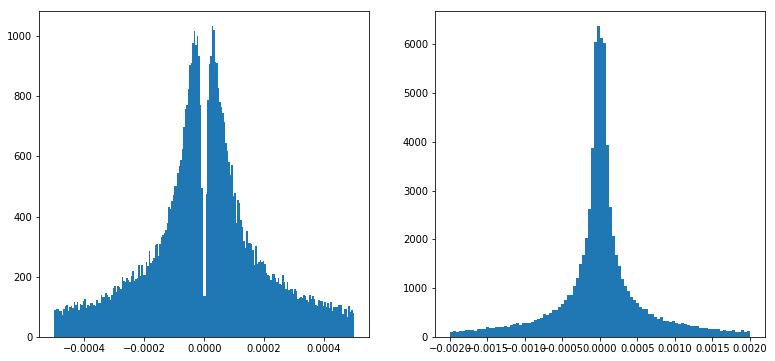

In [278]:
plt.figure(figsize=(13,6))
plt.subplot(121)
plt.hist(particles2[0.0005>abs(particles2.wv)]["wv"], bins=200)
plt.subplot(122)
tmp = plt.hist(particles2[0.002>abs(particles2.wv)]["wv"], bins=100)

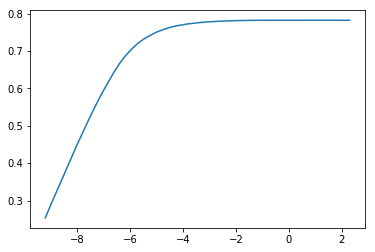

In [288]:
maxvals = np.linspace(np.log(0.0001), np.log(10.0), 50)
data = []
for maxval in maxvals:
    data.append(len(particles2[abs(particles2.wv)<np.exp(maxval)])/len(particles))
plt.plot(maxvals, data)    

/home/matsuzaki/.pyenv/versions/3.6.2/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


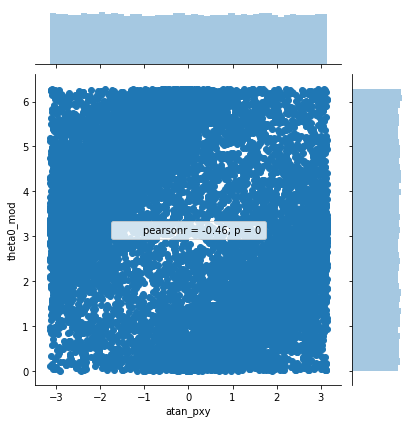

In [216]:
df = particles2
df["atan_pxy"] = np.arctan2(df["py"], df["px"])
df["theta0_mod"] = np.mod(df["theta0"], 2*np.pi)
sns.jointplot("atan_pxy", "theta0_mod", data=df)

今の仮設が正しいとすると、theta0とpx,pyから計算される角度は一致するはず。なにか仮設がおかしいか？

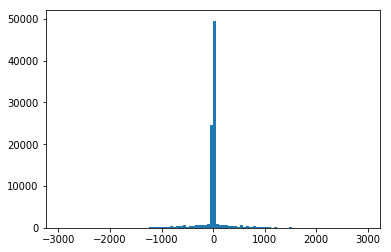

In [221]:
tmp=plt.hist(particles2["vz"], bins=100)

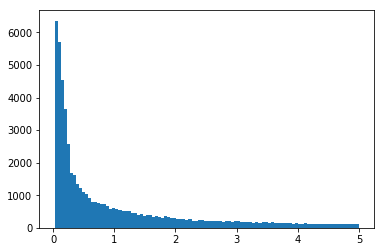

In [228]:
p = (particles2["px"]**2 + particles2["py"]**2 + particles2["pz"]**2).values
tmp = plt.hist(p[np.where(p<5.0)], bins=100)

運動エネルギーはGamma関数で表現できるか？

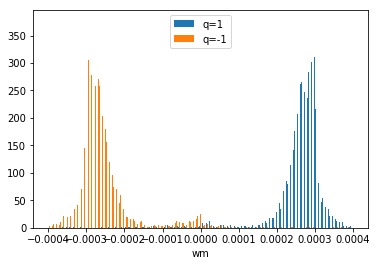

In [209]:
plt.xlabel("wm")
df = particles2[0.0005>abs(particles2.wv)]
wms = [df[(0.0004>abs(df.wm))&(df.q==q0)]["wm"].values for q0 in [-1,1]]
#wms = [df[(0.00028<df.wm)&(df.wm<0.0003)&(df.q==q0)]["wm"].values for q0 in [-1,1]]
gra = plt.hist(wms, bins=1000)
plt.legend(["q=1", "q=-1"])

wm がqの値で分離できている。qごとに正規分布に近いように見える。
wは外場から決まる。つまり、外場が一定とすると、質量はすべて同じということか？
いろいろな質量が現れているようにもみえる。

In [205]:
[(np.mean(wm), np.var(wm)) for wm in wms]

[(0.000261344756311854, 4.473884147247143e-09),
 (-0.0002529539822798955, 6.507577229838724e-09)]

中心位置は対照で、分散は同じ程度

# look 2d

# df = pd.merge(pd.merge(truth, hits, on="hit_id"), particles, on="particle_id")

In [63]:
max_nhit = np.max(df["nhits"])
pids = np.unique(df[df.nhits>max_nhit-2]["particle_id"].values)

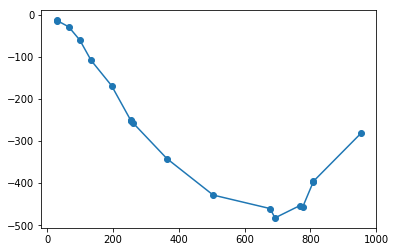

In [75]:
df0 = df[df.particle_id==pids[0]].sort_values(by="z")
x, y, z = [df[df.particle_id==pids[0]][lbl].values for lbl in ["x", "y", "z"]]
plt.plot(x, y, "o-")

In [41]:
df_size = pd.DataFrame(df.groupby("particle_id").size())
df_size.columns = ["count"]

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().